
# **КЛАСТЕРНЫЙ АНАЛИЗ**

Основные этапы КА в Python
1. Инициализация.
  1.   Импорт библиотек.
  2.   Импорт данных. Описание признаков.

2. Предобработка данных.
  1.   Первичная информация о данных.
  2.   Есть пропущенные значения?
  3.   Есть выбросы в данных?
  4.   Трансформация данных (при необходимости).

3. Кластеризация.
  1. Выбор метода кластеризации для конкретной задачи и типа данных.
  2. Определение количества кластеров: выбор оптимального числа кластеров с\
  использованием различных методов, таких как **метод локтя** и **индекс силуэта**.
  3. Применение выбранного метода кластеризации к данным.
  4. Визуализация полученных кластеров для анализа и интерпретации результатов.
  5. Интерпретация и анализ кластеров: \
анализ характеристик и особенностей каждого кластера,\
выявление закономерностей и выводы.


---



Данный шаблон выполнен на данных\
**`Protein Consumption in Europe.csv`**

описание признаков (переменных):

- `Country` - Страна
- `RedMeat`  - Мясо
- `WhiteMeat` - Птица
- `Eggs` - Яйца
- `Milk` - Молоко
- `Fish` - Рыба
- `Cereals` - Хлопья, каши
- `Starch` - Крахмалосодержащие продукты
- `Nuts` - Орехи
- `Fr&Veg` - Фрукты и овощи

# 1. Инициализация

## 1.1. Импорт библиотек

In [1]:
import numpy as np
import pandas as pd

# Визуализация
from matplotlib import pyplot as plt
#import plotly.express as px
import seaborn as sns

# Предобработка
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# Все, что пригодится для кластеризации
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

from sklearn.cluster import DBSCAN

# Устанавливаем стандартный формат и размер картинок
%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = [8, 4]

from scipy import stats

import warnings    # игнорировать предупреждения
warnings.filterwarnings('ignore')

In [2]:
 #Загрузка в текущей блокнот Colab

from google.colab import files
uploaded = files.upload()  # нажать кнопку Обзор и загрузить файл

Saving Protein Consumption in Europe.csv to Protein Consumption in Europe.csv


In [3]:
df = pd.read_csv('/content/Protein Consumption in Europe.csv', sep = ';', decimal = ',')
df.head(5)

,Country,RedMeat,WhiteMeat,Eggs,Milk,Fish,Cereals,Starch,Nuts,Fr&Veg
0,Albania,10.1,1.4,0.5,8.9,0.2,42.3,0.6,5.5,1.7
1,Austria,8.9,14.0,4.3,19.9,2.1,28.0,3.6,1.3,4.3
2,Belgium,13.5,9.3,4.1,17.5,4.5,26.6,5.7,2.1,4.0
3,Bulgaria,7.8,6.0,1.6,8.3,1.2,56.7,1.1,3.7,4.2
4,Czechoslovakia,9.7,11.4,2.8,12.5,2.0,34.3,5.0,1.1,4.0


# 2. Предобработка данных

#### **2.1.  Первичная информация о данных**.

In [4]:
df.info()   # первичные сведения о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Country    25 non-null     object 
 1   RedMeat    25 non-null     float64
 2   WhiteMeat  25 non-null     float64
 3   Eggs       25 non-null     float64
 4   Milk       25 non-null     float64
 5   Fish       25 non-null     float64
 6   Cereals    25 non-null     float64
 7   Starch     25 non-null     float64
 8   Nuts       25 non-null     float64
 9   Fr&Veg     25 non-null     float64
dtypes: float64(9), object(1)
memory usage: 2.1+ KB


In [5]:
df.isnull().sum() # количество пропущенных значений

Country      0
RedMeat      0
WhiteMeat    0
Eggs         0
Milk         0
Fish         0
Cereals      0
Starch       0
Nuts         0
Fr&Veg       0
dtype: int64

In [6]:
df_num = df.iloc[:,1:]  # отбор числовых данных для кластерного анализа
df_num.head(3)

,RedMeat,WhiteMeat,Eggs,Milk,Fish,Cereals,Starch,Nuts,Fr&Veg
0,10.1,1.4,0.5,8.9,0.2,42.3,0.6,5.5,1.7
1,8.9,14.0,4.3,19.9,2.1,28.0,3.6,1.3,4.3
2,13.5,9.3,4.1,17.5,4.5,26.6,5.7,2.1,4.0


##### **2.3. Есть выбросы?**


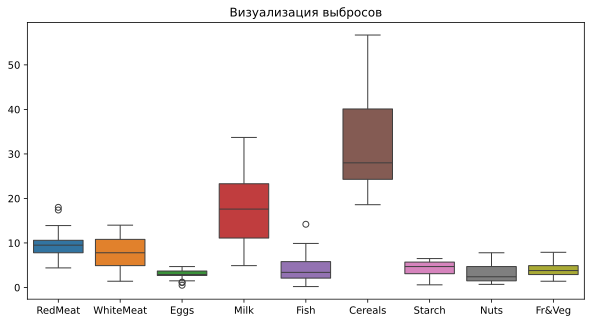

In [7]:
plt.figure(figsize=(10,5))
plt.title("Визуализация выбросов")
sns.boxplot(data=df_num);

**Вывод**. Признаки `ReadMeat`, `Eggs`, `Fish` имеют выбросы.

#### **2.4. Трансформация данных, участвующих в кластеризации.**
Нужно решить вопрос о преобразовании данных.\
Если значения признаков значительно отличаются,\
требуется выполнить преобразование.


Для трансформации чаще всего выбирается модель `MinMaxScaler`,\
которая преобразовывает все данные к единому отрезку `[a, b]`.

В рассматриваемом случае применим модель `RobustScaler`\
(используется при наличии выбросов).\
Построим модель и выполним трансформацию данных.\
`df_num` - числовые данные для трансформации\
`scaler` - имя модели (задается пользователем)\
`fit` - обучение модели\
`transform` - преобразование данных

In [8]:
scaler = RobustScaler()                   # построение модели трансформации
df_scaler = scaler.fit_transform(df_num)  # обучение и преобразование
df_scaler[:3]                             # массив преобразованных числовых данных

array([[ 0.21428571, -1.08474576, -2.4       , -0.71311475, -0.86486486,
         0.90506329, -1.57692308,  0.96875   , -1.05      ],
       [-0.21428571,  1.05084746,  1.4       ,  0.18852459, -0.35135135,
         0.        , -0.42307692, -0.34375   ,  0.25      ],
       [ 1.42857143,  0.25423729,  1.2       , -0.00819672,  0.2972973 ,
        -0.08860759,  0.38461538, -0.09375   ,  0.1       ]])

## 3. Кластеризация

#### **3.1. Выбор метода кластеризации для конкретной задачи и типа данных.**

#### **Модель 1. Агломеративная Кластеризация**
Выбор расстояний для кластеризации:\
между **объектами**\
между **кластерами**

In [9]:
# Расстояние между парой объектов

X = np.array(df_num.iloc[:2])

# Евклидово расстояние
print(pdist(X,metric='euclidean'))

# расстояние Манхэттен
print(pdist(X,metric='cityblock'))

# расстояние Минковского
print(pdist(X,metric='minkowski',p=3))

# расстояние Чебышева
print(pdist(X,metric='chebyshev'))

# расстояние Брея-Кертиса
print(pdist(X,metric='braycurtis'))

# расстояние Хэмминга
print(pdist(X,metric='hamming'))

[23.17628098]
[54.6]
[18.60274558]
[14.3]
[0.3464467]
[1.]


In [10]:
X

array([[10.1,  1.4,  0.5,  8.9,  0.2, 42.3,  0.6,  5.5,  1.7],
       [ 8.9, 14. ,  4.3, 19.9,  2.1, 28. ,  3.6,  1.3,  4.3]])

Расстояния между **объектами** (элементами):

`'euclidean'` Евклидово расстояние\
`'cityblock'` расстояние Манхэттена\
`'chebyshev'` расстояние Чебышева

Евклидово расстояние - хорошо подходит для данных, где все переменные \
имеют примерно одинаковое значение.

Расстояния между **кластерами**:

`'ward'` - метод Варда (минимизирует дисперсию объединяемых кластеров)\
Имеет тенденцию к нахождению кластеров\
приблизительного равного размера и имеющих гиперсферическую форму.

`'average'` - метод средних (использует среднее значение расстояний каждого\
наблюдения из двух наборов)\
`'complete'` метод дальнего соседа (использует максимальное
расстояния\
между всеми наблюдениями двух наборов)\
`'single'` - метод ближайшего соседа (использует минимальное расстояние между всеми наблюдениями двух наборов).


Что у нас есть для проведения кластерного анализа:\
`df` - исходный датафрeйм\
`df_scaler` - массив преобразованных числовых данных для кластерного анализа

##### **Выбор оптимального числа кластеров.**

Единого универсального метода определения оптимального числа кластеров \
не существует.

##### **Иерархическая кластеризация на основе дендрограммы**

Выполним иерархическую кластеризация для определения \
оптимального числа кластеров, \
построив дендрограмму по Евклидову расстоянию.


По умолчанию цветом выделяются 2 кластера.\
Если количество объектов (строк в таблице) небольшое, \
можно вывести имена объектов. Иначе выводится индекс объекта. \
Выведем названия стран:  `labels=df['Country'].to_list()`\
Вместо `'Country'` можно взять другой столбец. \
Зависит от исходных данных.

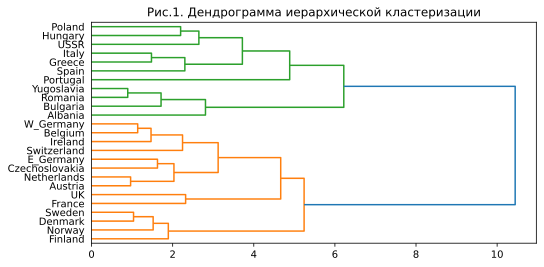

In [11]:
link = linkage(df_scaler, metric='euclidean', method='ward')   # расстояния выбраны
dendrogram(link, orientation='right',labels=df['Country'].to_list()) # дендрограмма
plt.title("Рис.1. Дендрограмма иерархической кластеризации")
plt.show()

In [12]:
link

array([[17.        , 24.        ,  0.89263366,  2.        ],
       [ 1.        , 13.        ,  0.96322098,  2.        ],
       [ 5.        , 19.        ,  1.03552644,  2.        ],
       [ 2.        , 23.        ,  1.13794383,  2.        ],
       [11.        , 28.        ,  1.46665466,  3.        ],
       [ 9.        , 12.        ,  1.47751005,  2.        ],
       [14.        , 27.        ,  1.51902041,  3.        ],
       [ 4.        ,  6.        ,  1.62567612,  2.        ],
       [ 3.        , 25.        ,  1.71393547,  3.        ],
       [ 7.        , 31.        ,  1.89302272,  4.        ],
       [26.        , 32.        ,  2.03158216,  4.        ],
       [10.        , 15.        ,  2.19642601,  2.        ],
       [20.        , 29.        ,  2.24367084,  4.        ],
       [18.        , 30.        ,  2.3007898 ,  3.        ],
       [ 8.        , 21.        ,  2.31968702,  2.        ],
       [22.        , 36.        ,  2.64623863,  3.        ],
       [ 0.        , 33.

**Выводы.** На дендрограмме наблюдаются 2 кластера или 4.

Рассмотрим другие параметры для построения дендрограммы.

Установим параметр `color_threshold=5` - пороговое значение \
для цветового кодирования кластеров на дендрограмме. \
Кластеры, расстояние между которыми больше 5,
будут окрашены в разные цвета. \
Таким образом, визуально дендрограмма разделит данные на 4 кластера.\
Возможно, 5 кластеров тоже можно рассмотреть.

Расстояние между кластерами `color_threshold` - на оси "Евклидово расстояние" (см. Рис 2.).

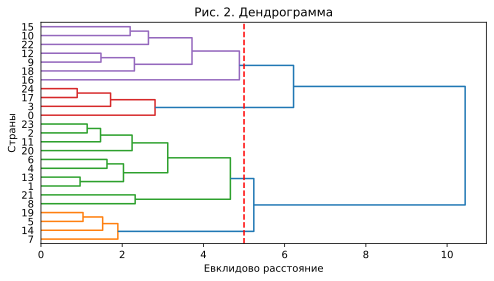

In [13]:
color_threshold = 5   # расстояние между кластерами
dendrogram(link, orientation='right', truncate_mode='lastp', p=40, color_threshold=color_threshold)
plt.title('Рис. 2. Дендрограмма')
plt.ylabel('Страны')
plt.xlabel('Евклидово расстояние')

plt.axvline(x=color_threshold, color='red', linestyle='--')
plt.show()

Проведение иерархического кластерного анализа на основе Евклидова расстояния

###### `'euclidean'` - расстояние между объектами (многомерными точками)
###### `'ward'`      - расстояние между кластерами
###### `df_scaler`   -  массив преобразованных числовых данных для кластерного анализа
###### `df`          - исходный массив

###### Дендрограмма отображает  4 кластера  

##### **Выбор оптимального числа кластеров.**
  Используя **метод локтя**

In [14]:
link_1 = linkage(df_scaler, metric='euclidean', method='ward')
link_1[:3] # посмотрим начало расчетов

array([[17.        , 24.        ,  0.89263366,  2.        ],
       [ 1.        , 13.        ,  0.96322098,  2.        ],
       [ 5.        , 19.        ,  1.03552644,  2.        ]])

Максимальное количество кластеров равно 25, по количеству объектов.\
Построим график расстояний между кластерами в зависимости от количества кластеров.\
Смотрим на каком шаге процесса формирования кластеров \
происходит первый сравнительно большой скачок расстояний.

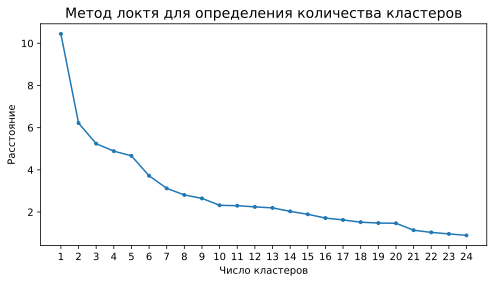

In [15]:
max_n = df_num.shape[0] # максимальное количество кластеров
xticks = np.arange(1,max_n)
yticks = sorted(link_1[:,2],reverse=True)
fig = plt.figure()
plt.title('Метод локтя для определения количества кластеров', size=14)
plt.xlabel('Число кластеров')
plt.ylabel('Расстояние')
plt.xticks(xticks)

plt.plot(xticks, yticks, marker='.')
plt.show()

Как мы видим на графике, расстояние становится резко меньше, начиная с 5-го кластера.\
Имеет смысл построить 5 и 6 кластеров и сравнить результаты кластеризации.

**Иерархическая кластеризация**

* Выполним **иерархическую кластеризацию** на основе Евклидова расстояния, для 5 кластеров.
* Добавим к исходному датафрейму `df` столбец `clustering1` - принадлежность объекта к кластеру.  

In [16]:
n_clusters=5
clustering1 = AgglomerativeClustering(n_clusters = n_clusters, affinity='euclidean', linkage='ward').fit_predict(df_scaler)
df['cluster1_agg'] = clustering1
df.head(5)                    # таблица исходных данных

,Country,RedMeat,WhiteMeat,Eggs,Milk,Fish,Cereals,Starch,Nuts,Fr&Veg,cluster1_agg
0,Albania,10.1,1.4,0.5,8.9,0.2,42.3,0.6,5.5,1.7,2
1,Austria,8.9,14.0,4.3,19.9,2.1,28.0,3.6,1.3,4.3,0
2,Belgium,13.5,9.3,4.1,17.5,4.5,26.6,5.7,2.1,4.0,0
3,Bulgaria,7.8,6.0,1.6,8.3,1.2,56.7,1.1,3.7,4.2,2
4,Czechoslovakia,9.7,11.4,2.8,12.5,2.0,34.3,5.0,1.1,4.0,0


Расчет средних значений признаков для каждого кластера.\
Для наглядности используем таблицы.

In [17]:
cluster_means = df.iloc[:,1:].groupby('cluster1_agg').mean()

# Используем оформление для таблицы данных, содержащей средние значения признаков для каждого кластера
(cluster_means
 .style
 .format("{:.1f}")
 .background_gradient(cmap='Blues', axis = 0)  # по столбцам
)

,RedMeat,WhiteMeat,Eggs,Milk,Fish,Cereals,Starch,Nuts,Fr&Veg
cluster1_agg,,,,,,,,,
0,12.4,10.8,3.8,19.3,3.4,25.6,4.9,1.8,4.1
1,8.0,6.5,2.8,14.2,3.8,37.9,4.4,4.8,5.7
2,7.1,4.7,1.2,9.4,0.8,51.1,2.0,5.0,3.0
3,9.8,7.1,3.2,26.7,8.2,22.7,4.5,1.2,2.1
4,6.2,3.7,1.1,4.9,14.2,27.0,5.9,4.7,7.9


*  Выведем объекты каждого кластера.
*  Получаем список стран в текущем кластере.

In [18]:
optimal_clusters = n_clusters
for cluster_number in range(optimal_clusters):
    cluster_country = df[df['cluster1_agg'] == cluster_number]['Country'].tolist()
    print(f"Кластер {cluster_number} включает следующие страны: {', '.join(cluster_country)}")

Кластер 0 включает следующие страны: Austria, Belgium, Czechoslovakia, E_Germany, France, Ireland, Netherlands, Switzerland, UK, W_Germany
Кластер 1 включает следующие страны: Greece, Hungary, Italy, Poland, Spain, USSR
Кластер 2 включает следующие страны: Albania, Bulgaria, Romania, Yugoslavia
Кластер 3 включает следующие страны: Denmark, Finland, Norway, Sweden
Кластер 4 включает следующие страны: Portugal


**Выводы.**  


###  **Модель №2. Метод k-средних**

Предположим, что у нас 5 кластеров. \
Применим метод k-means.
* `df_scaler`   -  массив преобразованных числовых данных для кластерного анализа
* `df`          - исходный массив
* `n_clusters`  - количество кластеров

Метод вовращает:

* `centroids`         - центры кластеров
* `inertia`           - критерий кластеризации
* `labels `           - метки классов

In [19]:
# Применение метода k-means
kmeans = KMeans(n_clusters=5, random_state=42).fit(df_scaler)

# Метод возвращает:

centroids = kmeans.cluster_centers_        # центры кластеров
inertia = kmeans.inertia_                  # один из критериев кластеризации
labels = kmeans.labels_                    # метки кластеров

In [20]:
print(centroids)        # центры кластеров
print(inertia)          # критерий кластеризации
print(labels)           # метки кластеров

[[-0.82738095 -0.31355932 -1.26666667 -0.56693989 -0.63513514  1.26793249
  -0.64102564  0.76041667 -0.31666667]
 [-0.29285714  0.73898305  0.52       -0.0295082  -0.10810811  0.06835443
   0.13076923 -0.3125      0.32      ]
 [ 1.80357143  0.30225989  1.1         0.27868852  0.09009009 -0.21940928
   0.07692308 -0.05208333  0.21666667]
 [-0.49107143 -0.6779661  -0.425      -0.52459016  1.14189189  0.35917722
  -0.27884615  1.0234375   1.6375    ]
 [ 0.125      -0.12711864  0.25        0.74385246  1.30405405 -0.33702532
  -0.05769231 -0.3828125  -0.8375    ]]
50.23473934605121
[0 1 2 0 1 4 1 4 2 3 0 2 3 1 4 1 3 0 3 4 2 2 0 2 0]


Применим эту же модель для разного числа кластеров, \
построим график типа  **каменистой осыпи**. \
Атрибут ```inertia_``` вернёт сумму расстояний от каждой точки данных до центра ближайшего с ней кластера.\
Таким образом, кластеризацию можно считать условно хорошей,\
когда инерция перестаёт сильно уменьшаться при увеличении числа кластеров.
*  `cluster_km` - метки классов при кластеризации k-means

In [21]:
df['cluster_km'] = pd.Series(labels)
df.head(5)

,Country,RedMeat,WhiteMeat,Eggs,Milk,Fish,Cereals,Starch,Nuts,Fr&Veg,cluster1_agg,cluster_km
0,Albania,10.1,1.4,0.5,8.9,0.2,42.3,0.6,5.5,1.7,2,0
1,Austria,8.9,14.0,4.3,19.9,2.1,28.0,3.6,1.3,4.3,0,1
2,Belgium,13.5,9.3,4.1,17.5,4.5,26.6,5.7,2.1,4.0,0,2
3,Bulgaria,7.8,6.0,1.6,8.3,1.2,56.7,1.1,3.7,4.2,2,0
4,Czechoslovakia,9.7,11.4,2.8,12.5,2.0,34.3,5.0,1.1,4.0,0,1


In [22]:
# Расчет средних значений признаков для каждого кластера
df1 = df.drop('cluster1_agg',axis=1)
cluster_means = df1.iloc[:,1:].groupby('cluster_km').mean()

# Используем оформление для таблицы данных, содержащей средние значения признаков для каждого кластера
(cluster_means
 .style
 .format("{:.1f}")
 .background_gradient(cmap='Blues', axis = 0)
)

,RedMeat,WhiteMeat,Eggs,Milk,Fish,Cereals,Starch,Nuts,Fr&Veg
cluster_km,,,,,,,,,
0,7.2,6.0,1.6,10.7,1.1,48.0,3.0,4.8,3.2
1,8.7,12.2,3.4,17.2,3.0,29.1,5.0,1.4,4.4
2,14.5,9.6,4.0,21.0,3.7,24.5,4.9,2.2,4.2
3,8.1,3.8,2.5,11.2,7.6,33.7,4.0,5.7,7.1
4,9.8,7.1,3.2,26.7,8.2,22.7,4.5,1.2,2.1


In [23]:
optimal_clusters = 5
# Выведем содержимое каждого кластера:

for cluster_number in range(0, optimal_clusters):
    # Получаем список стран в текущем кластере
    cluster_country = df[df['cluster_km'] == cluster_number]['Country'].tolist()
    print(f"Кластер {cluster_number} включает следующие страны: {', '.join(cluster_country)}")

Кластер 0 включает следующие страны: Albania, Bulgaria, Hungary, Romania, USSR, Yugoslavia
Кластер 1 включает следующие страны: Austria, Czechoslovakia, E_Germany, Netherlands, Poland
Кластер 2 включает следующие страны: Belgium, France, Ireland, Switzerland, UK, W_Germany
Кластер 3 включает следующие страны: Greece, Italy, Portugal, Spain
Кластер 4 включает следующие страны: Denmark, Finland, Norway, Sweden


**Выводы**.

Пример визуализации потребления продуктов в зависимости от кластеров.

<Axes: title={'center': 'Визуализация потребления продукта Nuts (орехи)'}, xlabel='cluster_km', ylabel='Nuts'>

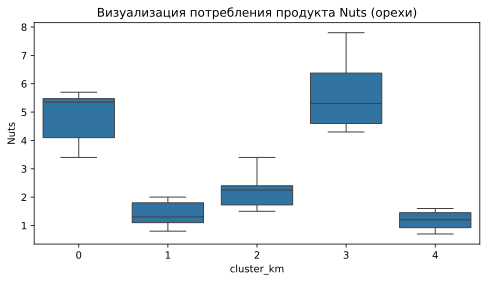

In [24]:
plt.title("Визуализация потребления продукта Nuts (орехи)")
sns.boxplot(data=df,x='cluster_km',y='Nuts')

**Выводы**.

**Сравнить кластеризации.**

**Вывод.**
Судя по графику коэффициента силуэта, первое оптимальное число \
кластеров 2, а второе - 5. Что согласуется с иерархической кластеризацией.

**Оптимальное число кластеров?**

In [25]:
inertias = []
silhouettes = []

possible_k = [i for i in range(2, 15)]
for k in possible_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df_scaler)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(df_scaler, cluster_labels))

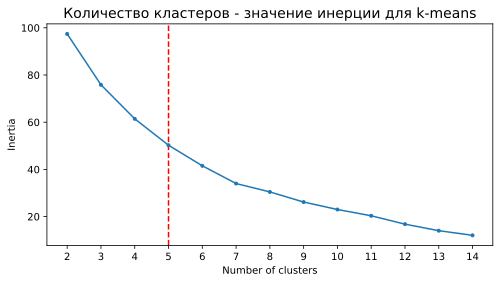

In [26]:
fig, ax = plt.subplots()
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Inertia')
ax.set_title('Количество кластеров - значение инерции для k-means', size=14)
ax.set_xticks(possible_k)
ax.axvline(x=5, color='red', linestyle='--')
plt.plot(possible_k, inertias, marker='.');

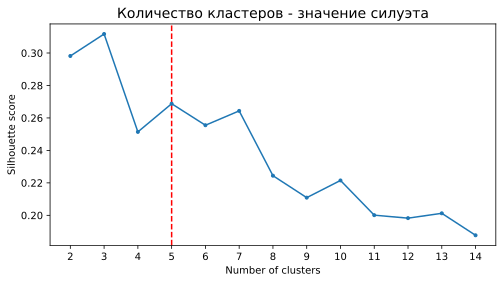

In [27]:
fig, ax = plt.subplots()
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
ax.set_title('Количество кластеров - значение силуэта', size=14)
ax.set_xticks(possible_k)
ax.axvline(x=5, color='red', linestyle='--')
plt.plot(possible_k, silhouettes, marker='.');

**Выводы.**

**Вывод.** Судя по графику коэффициента силуэта, первое оптимальное число \
кластеров 2, а второе - 5. Что согласуется с иерархической кластеризацией.